In [110]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points
import numpy as np
from altair import *

In [111]:
sf = pd.read_csv('data/sf/v1 073117/SFLicenseData.csv',low_memory=False)
sf = sf.drop_duplicates(subset=['DBA Name','Business Location'])
sf = sf.dropna(subset=['DBA Name','Business Location'])
sf = sf[(sf['Ownership Name'].str.contains('Coffee|Roaster')) 
    | (sf['DBA Name'].str.contains('Coffee|Roaster'))]
sf = sf[(pd.DatetimeIndex(sf['Business End Date']) >= '1/1/2017') 
    | sf['Business End Date'].isnull()==True]
sf = sf[['DBA Name', 'Street Address', 'City', 'State', 'Source Zipcode',
         'Neighborhoods - Analysis Boundaries','Business Location']]

businessLoc = sf['Business Location'].str.extract('\((.*)\)',expand=False)
businessCoords = businessLoc.str.split(', ',expand=True).astype(float)
businessCoords.columns = ['latitude','longitude']

sf = pd.concat([sf,businessCoords],axis=1)
sf = sf.dropna(subset=['Street Address','longitude','latitude'])

# change into geodataframe
sf['geometry'] = sf.apply(lambda z: Point( z.longitude,z.latitude), axis=1)
sf = gpd.GeoDataFrame(sf,crs = {'init': 'epsg:4326'})
sf = sf[['DBA Name', 'Street Address', 'City', 'State', 'Source Zipcode',
         'Neighborhoods - Analysis Boundaries','geometry']]

sf.head()

,DBA Name,Street Address,City,State,Source Zipcode,Neighborhoods - Analysis Boundaries,geometry
75,Bechellis Coffee Shop,2346 Chestnut St,San Francisco,CA,94123.0,Marina,POINT (-122.441968 37.800087)
338,Ocean Beach Coffee Shop,2898 Sloat Blvd,San Francisco,CA,94116.0,Sunset/Parkside,POINT (-122.505502 37.735572)
507,Europa Malvina Coffee Co,1411 Minnesota St,San Francisco,CA,94107.0,Bayview Hunters Point,POINT (-122.389662 37.752289)
1689,Flute Coffee And Wine Bar,750 Kearny St,San Francisco,CA,94108.0,Chinatown,POINT (-122.40491 37.795071)
3701,San Francisco Coffee Co,12 Sherman St,San Francisco,CA,94103.0,South of Market,POINT (-122.406695 37.777142)


In [112]:
sfBus = pd.read_csv('data/sf/v1 073117/stops.txt')
sfBus = sfBus[['stop_lat','stop_lon','stop_name']].drop_duplicates(subset=['stop_lat','stop_lon','stop_name'])
sfBus['geometry'] = sfBus.apply(lambda z: Point( z.stop_lon,z.stop_lat), axis=1)
sfBus = gpd.GeoDataFrame(sfBus,crs = {'init': 'epsg:4326'})
sfBus.head()

,stop_lat,stop_lon,stop_name,geometry
0,37.792357,-122.421010,Clay St & Polk St,POINT (-122.42101 37.792357)
1,37.793826,-122.409591,Clay St & Powell St,POINT (-122.409591 37.793826)
2,37.793653,-122.410823,Clay St & Mason St,POINT (-122.410823 37.79365300000001)
3,37.794682,-122.402770,Clay St & Montgomery St,POINT (-122.40277 37.794682)
4,37.792526,-122.419589,Clay St & Larkin St,POINT (-122.419589 37.792526)


In [113]:
def getNearestPoint(pt,searchPts):
    nearest = nearest_points(pt,searchPts.geometry.unary_union)[1]
    nearest = gpd.GeoDataFrame(searchPts[searchPts.geometry == nearest])
    name = nearest[nearest.columns[nearest.columns.str.contains('name|NAME|Name')]]
    x =name.iloc[0][0]
    y = nearest.geometry.distance(pt)
    if y.iloc[0] == 0.0:
        searchPts = searchPts.loc[[i for i in searchPts.index if i != nearest.head(1).index ],:]
        nearest = nearest_points(pt,searchPts.geometry.unary_union)[1]
        nearest = gpd.GeoDataFrame(searchPts[searchPts.geometry == nearest])
        name = nearest[nearest.columns[nearest.columns.str.contains('name|NAME|Name')]]
        x =name.iloc[0][0]
        y = nearest.geometry.distance(pt)
    try:
        y = float(y)
    except:
        y = 0.0
    return x,y

In [114]:
coffeeExtract = sf['geometry'].apply(lambda x: getNearestPoint(x,sf))
sf['nearestCoffeeDesc'] = coffeeExtract.apply(lambda x: x[0])
sf['nearestCoffeeDist'] = coffeeExtract.apply(lambda x: x[1])

In [115]:
busExtract = sf['geometry'].apply(lambda x: getNearestPoint(x,sfBus))
sf['nearestBusStopDesc'] = busExtract.apply(lambda x: x[0])
sf['nearestBusStopDist'] = busExtract.apply(lambda x: x[1])

In [116]:
sf['sbInd'] = sf['DBA Name'].str.contains('Starbuck')
sf = sf.reset_index()

In [117]:
aggFuncs = {'index':'count','nearestBusStopDist':'mean','nearestCoffeeDist':'mean'}

In [118]:
sb = sf[sf['sbInd']==True].groupby('Neighborhoods - Analysis Boundaries').agg(aggFuncs).reset_index()
not_sb = sf[sf['sbInd']==False].groupby('Neighborhoods - Analysis Boundaries').agg(aggFuncs).reset_index()

nsbRatios = sb.merge(not_sb,how='left',on='Neighborhoods - Analysis Boundaries',suffixes=['_sb','_nsb'])
nsbRatios = nsbRatios.fillna(0)
nsbRatios['nsbRatio'] = nsbRatios['index_nsb']/nsbRatios['index_sb']

In [119]:
nsbRatios.sort_values('nsbRatio',ascending=False)

,Neighborhoods - Analysis Boundaries,index_sb,nearestCoffeeDist_sb,nearestBusStopDist_sb,index_nsb,nearestCoffeeDist_nsb,nearestBusStopDist_nsb,nsbRatio
0,Castro/Upper Market,1,0.000207,0.000064,11,0.001297,0.000552,11.000000
17,Sunset/Parkside,1,0.000000,0.000134,11,0.003340,0.001240,11.000000
11,Outer Richmond,1,0.000762,0.001447,11,0.000954,0.000725,11.000000
13,Potrero Hill,1,0.000695,0.000569,9,0.000301,0.000979,9.000000
9,Noe Valley,1,0.001651,0.000071,7,0.002709,0.001340,7.000000
16,South of Market,4,0.000932,0.000608,22,0.000957,0.000845,5.500000
14,Presidio Heights,1,0.002817,0.000103,5,0.001185,0.000216,5.000000
10,North Beach,2,0.001965,0.000318,10,0.000896,0.000778,5.000000
5,Lone Mountain/USF,1,0.002678,0.000084,5,0.002061,0.000746,5.000000
15,Russian Hill,1,0.000108,0.000346,4,0.001013,0.000572,4.000000


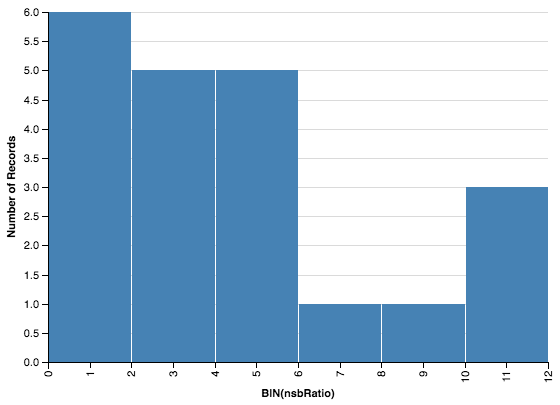

In [120]:
Chart(nsbRatios[['nsbRatio']]).mark_bar().encode(
    x=X('nsbRatio',
        bin=Bin(maxbins=10,),
       ),
    y='count(*)',
)

In [122]:
nsbRatios.to_csv('sf_ratios_081117.csv',index=False)